In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Thu Jan 25 03:33:13 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   39C    P0    45W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.9999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 7432
-rw-rw-r-- 1 scpark scpark   96826  1월 25 03:33 events.out.tfevents.1706121112.GPUSVR11
-rw-rw-r-- 1 scpark scpark     222  1월 25 03:32 events.out.tfevents.1706121042.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7471539  1월 25 03:32 save_0
-rw-rw-r-- 1 scpark scpark     222  1월 25 03:30 events.out.tfevents.1706121020.GPUSVR11
-rw-rw-r-- 1 scpark scpark   28266  1월 25 03:30 events.out.tfevents.1706120937.GPUSVR11


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

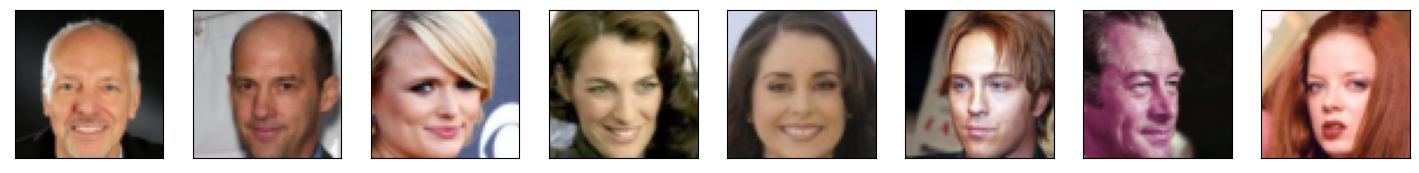

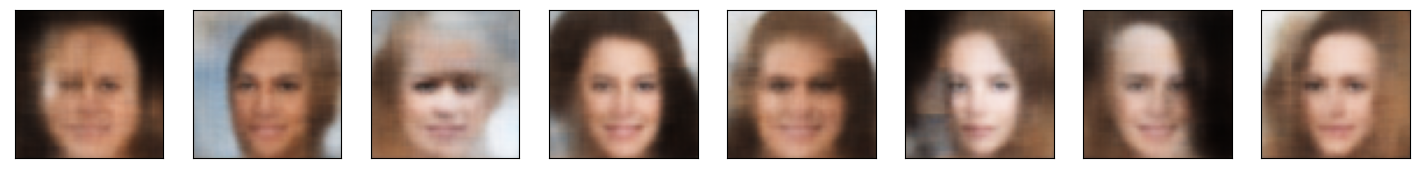

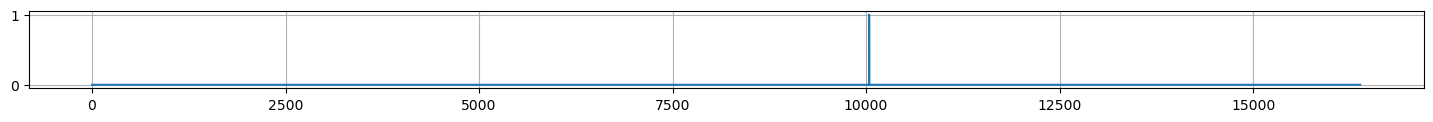

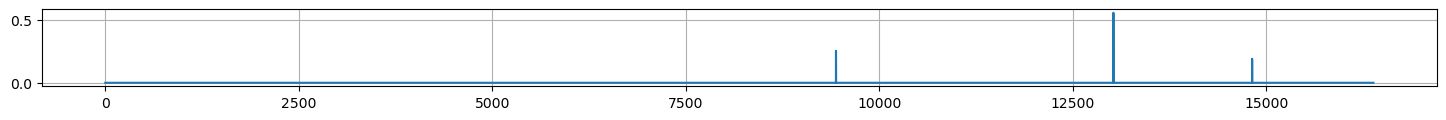

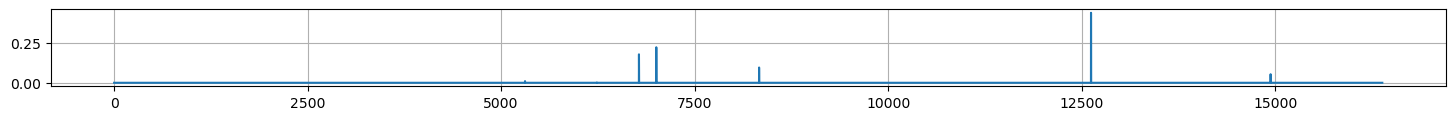

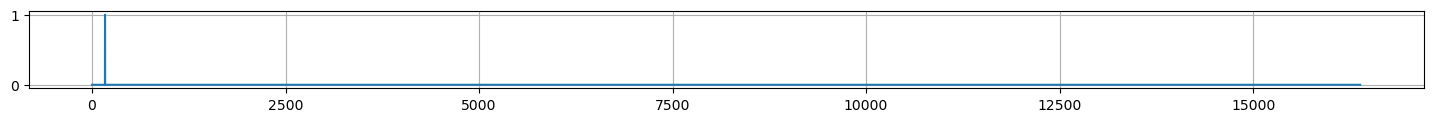

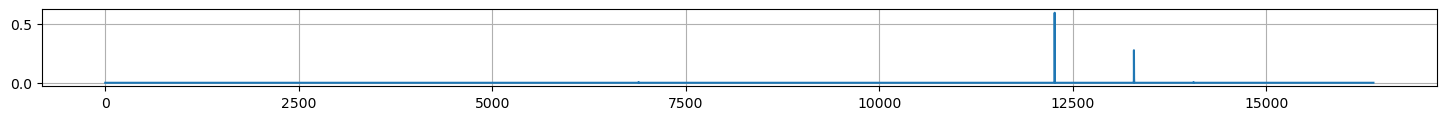

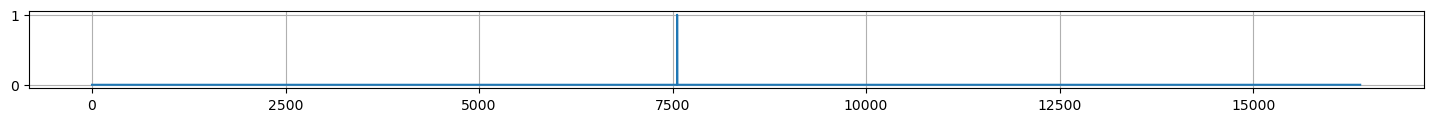

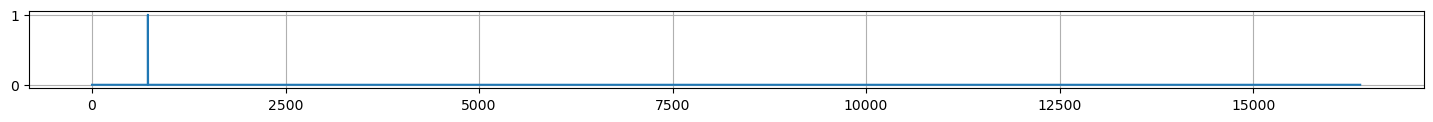

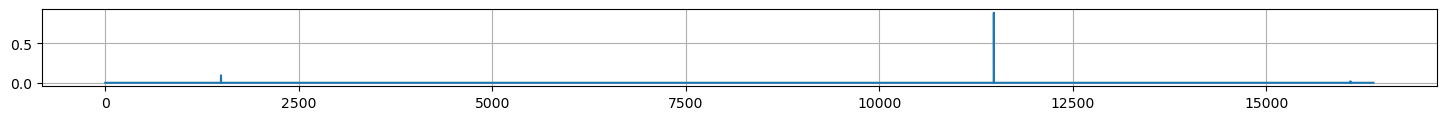

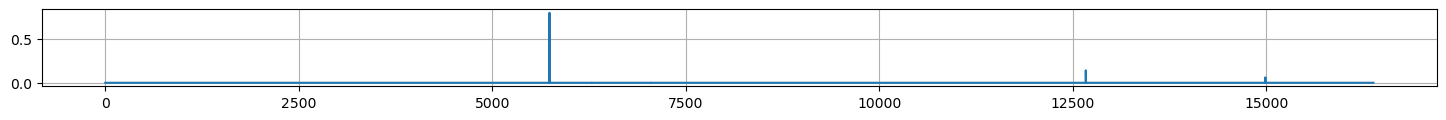

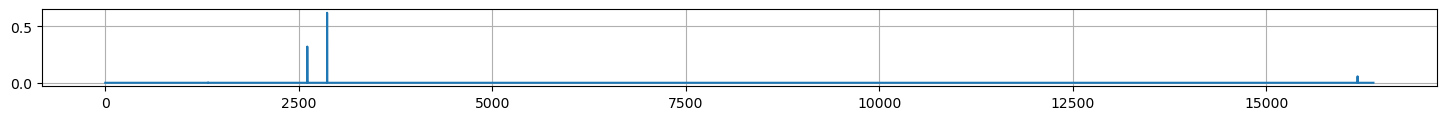

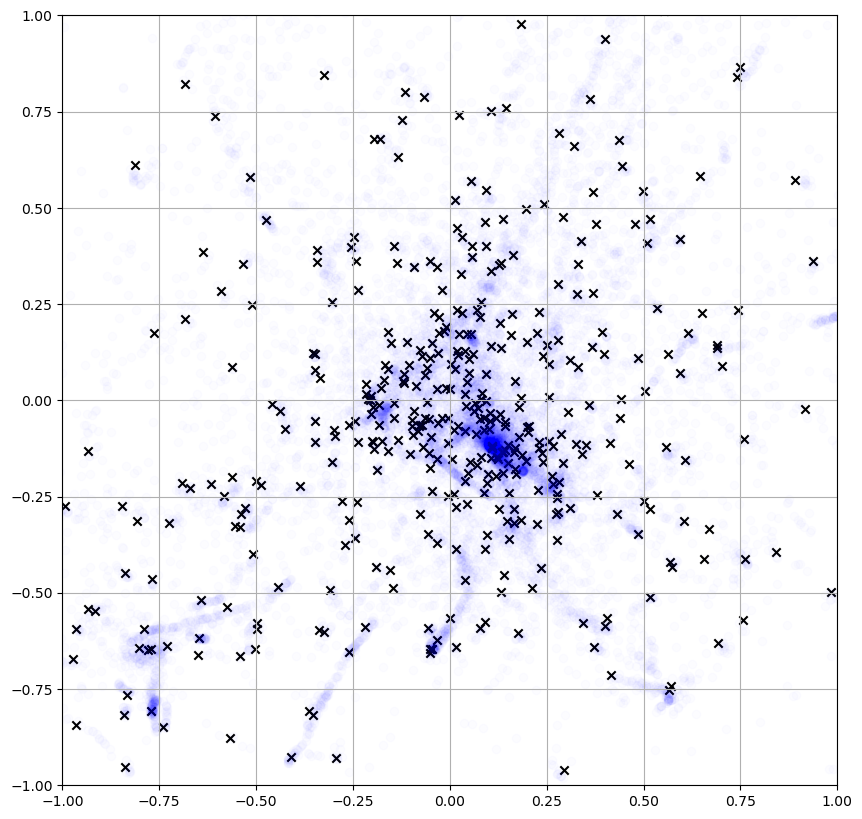

256001
lse_loss -322.8200988769531
commit_loss 0.006012805737555027
recon_loss 0.017990916967391968
256002
lse_loss -325.4262390136719
commit_loss 0.004881068132817745
recon_loss 0.01697426661849022
256003
lse_loss -319.29302978515625
commit_loss 0.006586857605725527
recon_loss 0.016819974407553673
256004
lse_loss -326.32086181640625
commit_loss 0.0051760608330369
recon_loss 0.01679011434316635
256005
lse_loss -321.3962097167969
commit_loss 0.005270408932119608
recon_loss 0.020030979067087173
256006
lse_loss -318.8961181640625
commit_loss 0.005242448300123215
recon_loss 0.018232494592666626
256007
lse_loss -324.4448547363281
commit_loss 0.005215290933847427
recon_loss 0.018432900309562683
256008
lse_loss -320.9217224121094
commit_loss 0.0052020130679011345
recon_loss 0.017503531649708748
256009
lse_loss -325.9402160644531
commit_loss 0.005757590755820274
recon_loss 0.019646063446998596
256010
lse_loss -322.9881896972656
commit_loss 0.005260969512164593
recon_loss 0.017496420070528984
2

256084
lse_loss -312.9399719238281
commit_loss 0.005839990451931953
recon_loss 0.016392983496189117
256085
lse_loss -320.6070251464844
commit_loss 0.00541088730096817
recon_loss 0.0181778185069561
256086
lse_loss -319.61322021484375
commit_loss 0.005539209581911564
recon_loss 0.019848058000206947
256087
lse_loss -321.0387268066406
commit_loss 0.005111312959343195
recon_loss 0.017482735216617584
256088
lse_loss -322.17425537109375
commit_loss 0.004867035895586014
recon_loss 0.018865574151277542
256089
lse_loss -325.6880798339844
commit_loss 0.00579421129077673
recon_loss 0.017566164955496788
256090
lse_loss -319.864013671875
commit_loss 0.00628275889903307
recon_loss 0.018262825906276703
256091
lse_loss -321.4991760253906
commit_loss 0.005616093520075083
recon_loss 0.019522113725543022
256092
lse_loss -318.59515380859375
commit_loss 0.005723489448428154
recon_loss 0.017787616699934006
256093
lse_loss -318.5910949707031
commit_loss 0.0058556958101689816
recon_loss 0.018987037241458893
25

lse_loss -307.5281982421875
commit_loss 0.005990819074213505
recon_loss 0.022374838590621948
256167
lse_loss -303.9818420410156
commit_loss 0.006587434094399214
recon_loss 0.018514424562454224
256168
lse_loss -306.0122985839844
commit_loss 0.006278914399445057
recon_loss 0.018300754949450493
256169
lse_loss -309.29595947265625
commit_loss 0.005580428056418896
recon_loss 0.018234677612781525
256170
lse_loss -294.62255859375
commit_loss 0.006084981374442577
recon_loss 0.01877749338746071
256171
lse_loss -311.66357421875
commit_loss 0.005816787015646696
recon_loss 0.01783173531293869
256172
lse_loss -304.7060852050781
commit_loss 0.005963585339486599
recon_loss 0.017487816512584686
256173
lse_loss -296.892578125
commit_loss 0.005387392360717058
recon_loss 0.02054353803396225
256174
lse_loss -306.4871826171875
commit_loss 0.006049945019185543
recon_loss 0.02053036540746689
256175
lse_loss -307.4892272949219
commit_loss 0.005775428377091885
recon_loss 0.019183479249477386
256176
lse_loss -3

256249
lse_loss -322.82232666015625
commit_loss 0.00517965666949749
recon_loss 0.01760246977210045
256250
lse_loss -316.77587890625
commit_loss 0.004864099435508251
recon_loss 0.01621890626847744
256251
lse_loss -324.37677001953125
commit_loss 0.005592123605310917
recon_loss 0.018702175468206406
256252
lse_loss -321.20550537109375
commit_loss 0.005208504386246204
recon_loss 0.017985250800848007
256253
lse_loss -304.22650146484375
commit_loss 0.004631179850548506
recon_loss 0.017501791939139366
256254
lse_loss -318.42156982421875
commit_loss 0.004591029137372971
recon_loss 0.01876562274992466
256255
lse_loss -321.1963195800781
commit_loss 0.005656423047184944
recon_loss 0.018130451440811157
256256
lse_loss -295.0118408203125
commit_loss 0.005050920881330967
recon_loss 0.017093714326620102
256257
lse_loss -322.2584533691406
commit_loss 0.005173398181796074
recon_loss 0.019376017153263092
256258
lse_loss -321.33245849609375
commit_loss 0.0049302708357572556
recon_loss 0.016528774052858353

256334
lse_loss -324.4318542480469
commit_loss 0.005403122864663601
recon_loss 0.017169959843158722
256335
lse_loss -310.3514709472656
commit_loss 0.005363050848245621
recon_loss 0.01648380421102047
256336
lse_loss -320.7600402832031
commit_loss 0.004908972419798374
recon_loss 0.017647122964262962
256337
lse_loss -308.7436218261719
commit_loss 0.004752852022647858
recon_loss 0.01618151366710663
256338
lse_loss -322.5941162109375
commit_loss 0.00460687093436718
recon_loss 0.019559074193239212
256339
lse_loss -307.0958251953125
commit_loss 0.006174909882247448
recon_loss 0.020194072276353836
256340
lse_loss -313.199462890625
commit_loss 0.006166035309433937
recon_loss 0.017985735088586807
256341
lse_loss -311.7219543457031
commit_loss 0.006515958346426487
recon_loss 0.01927838660776615
256342
lse_loss -315.9109191894531
commit_loss 0.00464670080691576
recon_loss 0.017150219529867172
256343
lse_loss -323.928955078125
commit_loss 0.0056883241049945354
recon_loss 0.01906130462884903
256344


lse_loss -314.1221923828125
commit_loss 0.005633963271975517
recon_loss 0.016716482117772102
256417
lse_loss -318.30084228515625
commit_loss 0.005024328827857971
recon_loss 0.018905792385339737
256418
lse_loss -322.9932556152344
commit_loss 0.004925700835883617
recon_loss 0.019817683845758438
256419
lse_loss -316.3605651855469
commit_loss 0.005709636025130749
recon_loss 0.01815727911889553
256420
lse_loss -318.94720458984375
commit_loss 0.005435563623905182
recon_loss 0.01900574378669262
256421
lse_loss -312.39263916015625
commit_loss 0.006537902634590864
recon_loss 0.01910187304019928
256422
lse_loss -321.5321350097656
commit_loss 0.0050390129908919334
recon_loss 0.016990287229418755
256423
lse_loss -313.53863525390625
commit_loss 0.005586622282862663
recon_loss 0.01871279813349247
256424
lse_loss -319.90435791015625
commit_loss 0.005423181690275669
recon_loss 0.01965927891433239
256425
lse_loss -321.55584716796875
commit_loss 0.005627566948533058
recon_loss 0.018602943047881126
25642

lse_loss -317.25
commit_loss 0.005790420342236757
recon_loss 0.019038323312997818
256501
lse_loss -315.4071960449219
commit_loss 0.005762829910963774
recon_loss 0.021482383832335472
256502
lse_loss -318.3933410644531
commit_loss 0.005080481991171837
recon_loss 0.020055174827575684
256503
lse_loss -322.279052734375
commit_loss 0.0060173096135258675
recon_loss 0.0201033316552639
256504
lse_loss -319.5000915527344
commit_loss 0.004745054990053177
recon_loss 0.0165477953851223
256505
lse_loss -319.950439453125
commit_loss 0.005221843719482422
recon_loss 0.018924707546830177
256506
lse_loss -320.3919372558594
commit_loss 0.005371106788516045
recon_loss 0.019143464043736458
256507
lse_loss -320.430419921875
commit_loss 0.005978385917842388
recon_loss 0.020004238933324814
256508
lse_loss -320.2286376953125
commit_loss 0.004976150579750538
recon_loss 0.019362863153219223
256509
lse_loss -320.17120361328125
commit_loss 0.005095783155411482
recon_loss 0.017305543646216393
256510
lse_loss -314.23

256584
lse_loss -310.4277648925781
commit_loss 0.005343166179955006
recon_loss 0.019408442080020905
256585
lse_loss -323.35491943359375
commit_loss 0.005372064188122749
recon_loss 0.01569143682718277
256586
lse_loss -318.0306396484375
commit_loss 0.0053728981874883175
recon_loss 0.018348313868045807
256587
lse_loss -321.0393371582031
commit_loss 0.005208587273955345
recon_loss 0.01791907474398613
256588
lse_loss -320.86468505859375
commit_loss 0.005738810636103153
recon_loss 0.017624136060476303
256589
lse_loss -310.0345764160156
commit_loss 0.005604308098554611
recon_loss 0.01856164261698723
256590
lse_loss -319.5426025390625
commit_loss 0.005149736534804106
recon_loss 0.01785118132829666
256591
lse_loss -319.7647399902344
commit_loss 0.00588081032037735
recon_loss 0.01733444258570671
256592
lse_loss -320.99786376953125
commit_loss 0.005356471985578537
recon_loss 0.018185673281550407
256593
lse_loss -312.0368957519531
commit_loss 0.005474850535392761
recon_loss 0.018766634166240692
25

256669
lse_loss -319.6037292480469
commit_loss 0.0047984980046749115
recon_loss 0.018741212785243988
256670
lse_loss -314.2425231933594
commit_loss 0.004715152084827423
recon_loss 0.01516101136803627
256671
lse_loss -320.9534606933594
commit_loss 0.005582363810390234
recon_loss 0.017180999740958214
256672
lse_loss -322.8740539550781
commit_loss 0.005463100969791412
recon_loss 0.018139317631721497
256673
lse_loss -325.4443359375
commit_loss 0.005183110013604164
recon_loss 0.01734274812042713
256674
lse_loss -322.7596740722656
commit_loss 0.005742525216192007
recon_loss 0.017568597570061684
256675
lse_loss -320.03924560546875
commit_loss 0.005087694153189659
recon_loss 0.018122363835573196
256676
lse_loss -322.7119140625
commit_loss 0.00552776176482439
recon_loss 0.0186472050845623
256677
lse_loss -320.2322692871094
commit_loss 0.005506253335624933
recon_loss 0.017893780022859573
256678
lse_loss -320.6663818359375
commit_loss 0.004868405871093273
recon_loss 0.015992753207683563
256679
ls

256753
lse_loss -324.3539733886719
commit_loss 0.005625189282000065
recon_loss 0.017343929037451744
256754
lse_loss -321.4004211425781
commit_loss 0.006006808951497078
recon_loss 0.019319811835885048
256755
lse_loss -322.722900390625
commit_loss 0.00515324342995882
recon_loss 0.018536092713475227
256756
lse_loss -323.0945129394531
commit_loss 0.005302491597831249
recon_loss 0.019314445555210114
256757
lse_loss -318.85699462890625
commit_loss 0.005511952564120293
recon_loss 0.018462305888533592
256758
lse_loss -318.7193908691406
commit_loss 0.005717487074434757
recon_loss 0.01926238462328911
256759
lse_loss -320.3883361816406
commit_loss 0.005702226422727108
recon_loss 0.01876385509967804
256760
lse_loss -318.0076904296875
commit_loss 0.0049780383706092834
recon_loss 0.017692625522613525
256761
lse_loss -313.5558776855469
commit_loss 0.005876555107533932
recon_loss 0.01916198991239071
256762
lse_loss -324.8426818847656
commit_loss 0.005163480527698994
recon_loss 0.017927387729287148
256

lse_loss -324.05377197265625
commit_loss 0.004498939495533705
recon_loss 0.01792810671031475
256838
lse_loss -324.15594482421875
commit_loss 0.005482031032443047
recon_loss 0.01862962730228901
256839
lse_loss -322.475341796875
commit_loss 0.005409060046076775
recon_loss 0.019528742879629135
256840
lse_loss -320.0468444824219
commit_loss 0.005014908500015736
recon_loss 0.018005691468715668
256841
lse_loss -325.7760314941406
commit_loss 0.005977565422654152
recon_loss 0.018599271774291992
256842
lse_loss -316.2084655761719
commit_loss 0.004248729441314936
recon_loss 0.017327185720205307
256843
lse_loss -316.7672119140625
commit_loss 0.006765872240066528
recon_loss 0.019914794713258743
256844
lse_loss -324.7809143066406
commit_loss 0.004966249689459801
recon_loss 0.016711408272385597
256845
lse_loss -321.36053466796875
commit_loss 0.005663434974849224
recon_loss 0.017599252983927727
256846
lse_loss -322.92156982421875
commit_loss 0.0055335769429802895
recon_loss 0.017875518649816513
25684

256922
lse_loss -319.6560363769531
commit_loss 0.005419821012765169
recon_loss 0.01768702082335949
256923
lse_loss -320.3173522949219
commit_loss 0.006187343504279852
recon_loss 0.0202597938477993
256924
lse_loss -326.3961486816406
commit_loss 0.005534573458135128
recon_loss 0.017769750207662582
256925
lse_loss -318.87457275390625
commit_loss 0.005585249979048967
recon_loss 0.01810656115412712
256926
lse_loss -320.7428283691406
commit_loss 0.005915186367928982
recon_loss 0.01802365668118


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

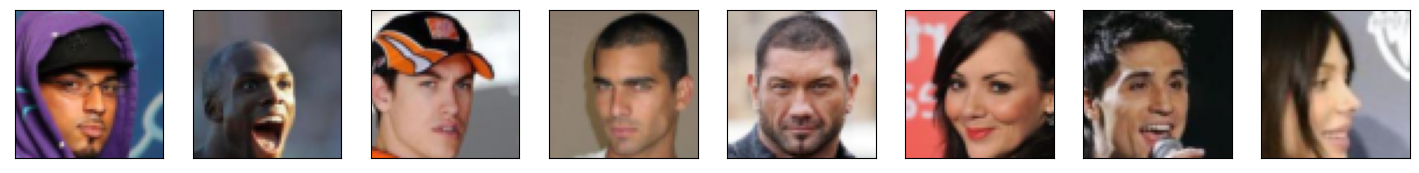

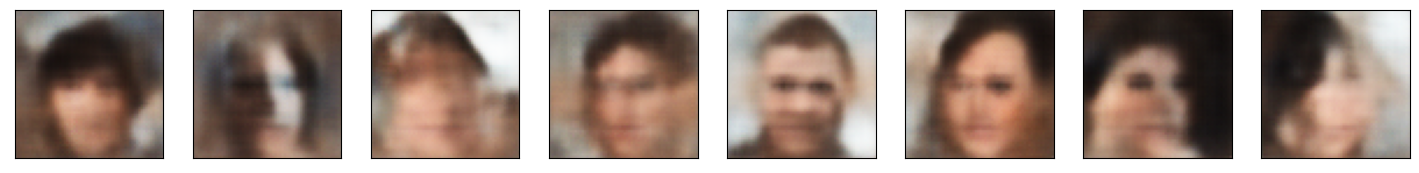

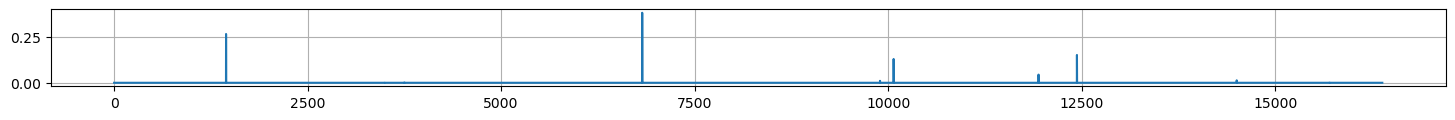

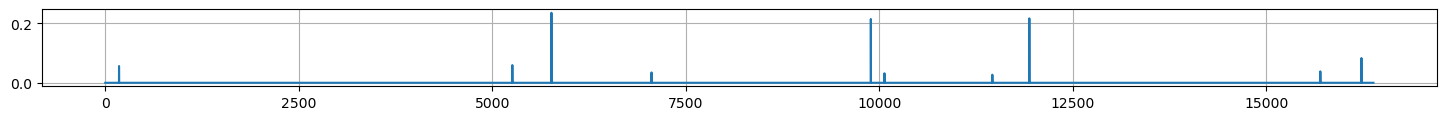

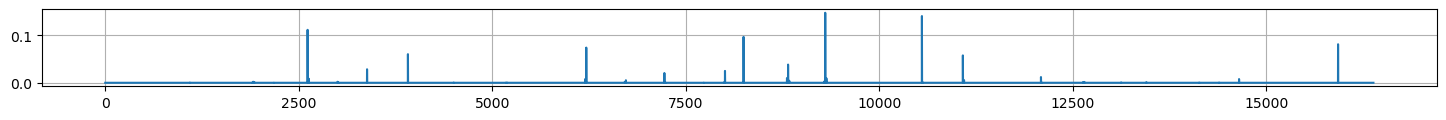

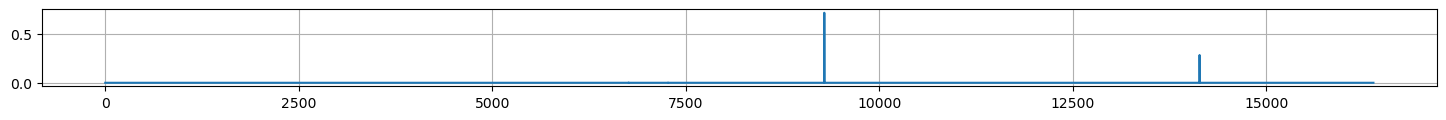

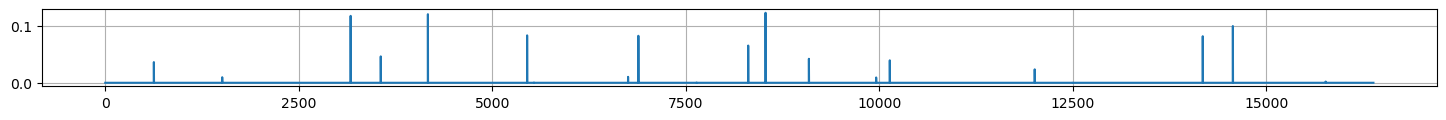

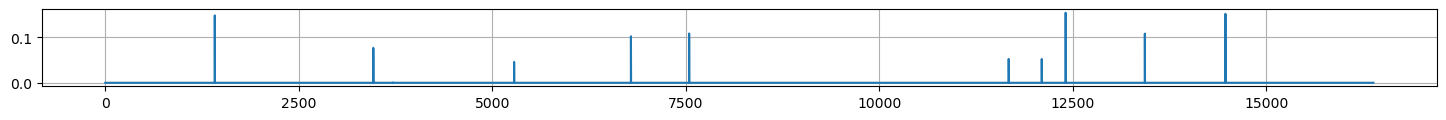

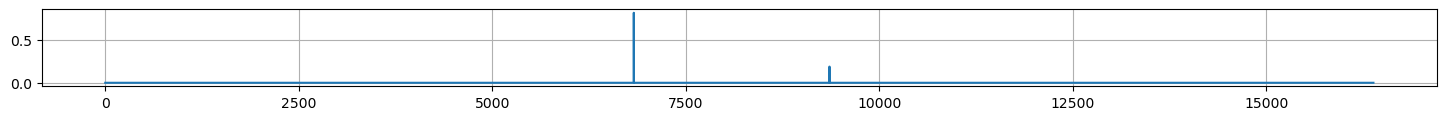

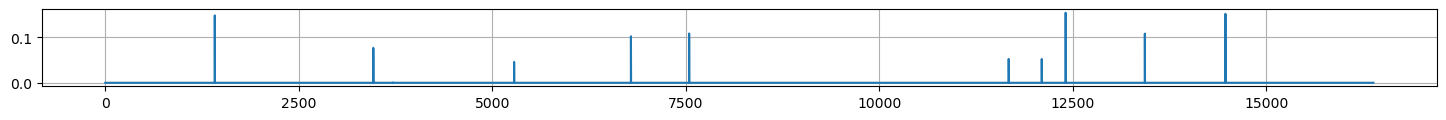

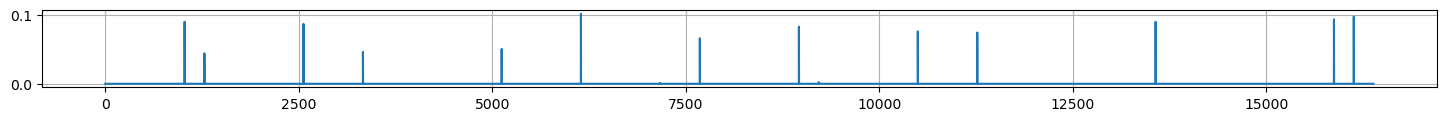

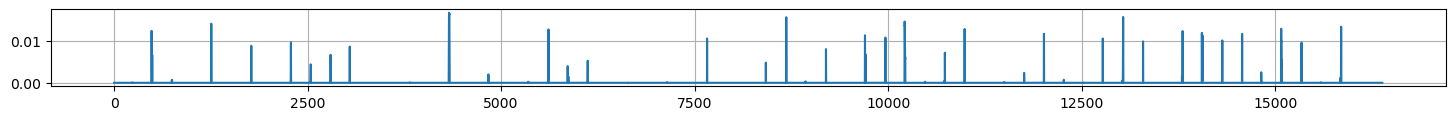

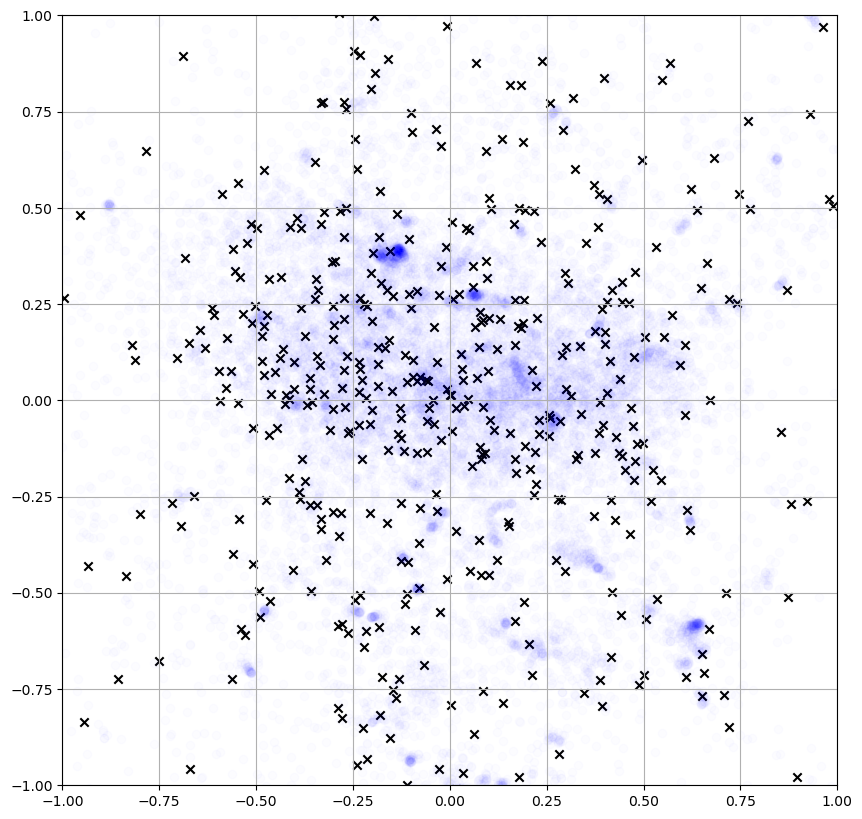

In [12]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid()
plt.show() 